**Nuclei segmentation in whole slide H&E images**

using custom model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [2]:
import os
from glob import glob

# CHANGE PATH

pth = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40'  # path of ndpi files
WSIs = sorted(glob(f'{pth}\*.ndpi'))

In [3]:
WSIs[:20]

['\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0001.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0002.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0003.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0004.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0005.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0006.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0007.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0008.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0009.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0010.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monke

Load just 1 image and show (takes a couple min)

In [4]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 200  # which image in directory list you are loading

# you might need to run "pip install imagecodecs" if you get jpeg compression error

img = imread(WSIs[ind])
n_channel = 1 if img[0].ndim == 2 else img[0].shape[-1]  #If no third

img = img/255

In [6]:
# display WSI image and also show a zoomed in region in a separate subplot
# show_image(img, crop_x=10000, crop_y=10000, tile_size=1024)

In [5]:
import json
from stardist.models import Config2D, StarDist2D

def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

#
# CHANGE RIGHT MODEL
model = load_model(r"\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_ft_11_21_2023_lr_0.001_epochs_400_pt_40")

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_ft_11_21_2023_lr_0.001_epochs_400_pt_40\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.618122427060411, nms=0.3) 



To save prediction outputs, I save as geojson file.
By reading this template geojson file, I get the right type info that I need to save

In [6]:
n_channel = 1 if imread(WSIs[0]).ndim == 2 else imread(WSIs[0]).shape[-1]  #If no third

In [7]:
import json

def save_json(result, out_pth, name):
    """Saves a geojson file with centroids and contours for StarDist output. Useful for loading into qupath"""
    coords = result['coord']
    points = result['points']

    json_data = []

    for i in range(len(points)):
        point = points[i]
        contour = coords[i]
        centroid = [int(point[0]), int(point[1])]
        contour = [[float(coord) for coord in xy[::-1]] for xy in contour]

        # Create a new dictionary for each contour
        dict_data = {
            "centroid": [centroid],
            "contour": [contour]
        }

        json_data.append(dict_data)

    new_fn = name[:-5] + '.json'

    with open(os.path.join(out_pth, new_fn),'w') as outfile:
        json.dump(json_data, outfile)
    print('Finished',new_fn)

In [10]:
# Segment all WSIs -- takes about 2-5 minutes per whole slide image to segment, about 3 minutes to save geojson file

date = '11_21_23'

out_pth_json = os.path.join(pth,f'StarDist_{date}','json')
out_pth_tif = os.path.join(pth,f'StarDist_{date}','tif')

if not os.path.exists(out_pth_json):
    os.mkdir(out_pth_json)

if not os.path.exists(out_pth_tif):
    os.mkdir(out_pth_tif)

for img_pth in WSIs:
    name = os.path.basename(img_pth)

    if not os.path.exists(os.path.join(out_pth_json, (name[:-5] + '.json'))):
        print(f'Starting {name}')

        img = imread(img_pth)
        img = img/255  # normalization used to train model
        labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

        print('Saving json...')
        save_json(polys, out_pth_json, name)

        # tif file is like 3 GB usually, so only uncomment next part if you are ok with that
        #print('Saving tif...')
        #imwrite(os.path.join(out_pth_tif, name[:-5] + '.tif'), labels)
    else:
        print(f'Skipping {name}')

Skipping monkey_fetus_40_0001.ndpi
Skipping monkey_fetus_40_0002.ndpi
Skipping monkey_fetus_40_0003.ndpi
Skipping monkey_fetus_40_0004.ndpi
Skipping monkey_fetus_40_0005.ndpi
Skipping monkey_fetus_40_0006.ndpi
Skipping monkey_fetus_40_0007.ndpi
Skipping monkey_fetus_40_0008.ndpi
Skipping monkey_fetus_40_0009.ndpi
Skipping monkey_fetus_40_0010.ndpi
Skipping monkey_fetus_40_0011.ndpi
Skipping monkey_fetus_40_0012.ndpi
Skipping monkey_fetus_40_0013.ndpi
Skipping monkey_fetus_40_0014.ndpi
Skipping monkey_fetus_40_0015.ndpi
Skipping monkey_fetus_40_0016.ndpi
Skipping monkey_fetus_40_0017.ndpi
Skipping monkey_fetus_40_0018.ndpi
Skipping monkey_fetus_40_0019.ndpi
Skipping monkey_fetus_40_0020.ndpi
Skipping monkey_fetus_40_0021.ndpi
Starting monkey_fetus_40_0022.ndpi
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


 56%|█████▌    | 49/88 [04:13<03:21,  5.17s/it]


KeyboardInterrupt: 

In [8]:
WSIs[285]

'\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0286.ndpi'

In [9]:
for img_pth in WSIs:

    name = os.path.basename(WSIs[285])

    print(f'Starting {name}')

    img = imread(img_pth)
    img = img/255  # normalization used to train model
    labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

    # print('Saving json...')
    # save_json(polys, out_pth_json, name)

    break

    # tif file is like 3 GB usually, so only uncomment next part if you are ok with that
    #print('Saving tif...')
    #imwrite(os.path.join(out_pth_tif, name[:-5] + '.tif'), labels)

Starting monkey_fetus_40_0286.ndpi
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 390/390 [13:37<00:00,  2.10s/it]


In [23]:
model

StarDist2D(offshoot_model): YXC → YXC
├─ Directory: \\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_ft_11_21_2023_lr_0.001_epochs_400_pt_40\offshoot_model
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=[1, 1], train_epochs=400, t

In [ ]:
# show_image(labels, crop_x=10000, crop_y=10000, tile_size=1024, cmap=cmap)
# show_image(img, crop_x, crop_y, tile_size, cmap=cmap)

In [10]:
#cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
#cropped_lbl = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

tile_size = 512*2

y_cor = 5100
y_cor_end = y_cor + tile_size
x_cor = 14200
x_cor_end = x_cor + tile_size

cropped_img = img[y_cor:y_cor_end, x_cor:x_cor_end]
cropped_lbl = labels[y_cor:y_cor_end, x_cor:x_cor_end]

lbl_cmap = random_label_cmap()

In [ ]:
lbl_cmap.colors

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img)
plt.axis('off')
plt.show()

In [ ]:
model_pre = StarDist2D.from_pretrained('2D_versatile_he')

In [ ]:
labels_pre, polys_pre = model_pre.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

In [18]:
img.shape

(54912, 96000, 3)

In [21]:
tile_size = 512*2

y_cor = 5100
y_cor_end = y_cor + tile_size
x_cor = 14200
x_cor_end = x_cor + tile_size

print([y_cor,y_cor_end, x_cor,x_cor_end])

[5100, 6124, 14200, 15224]


In [24]:
labels.shape

(54912, 96000)

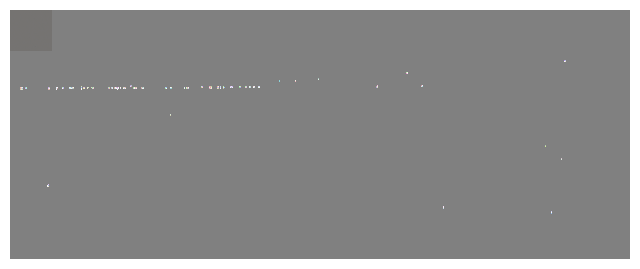

In [26]:
cropped_lbl = labels[0:y_cor_end, 0:x_cor_end]

plt.figure(figsize=(8, 8))
plt.imshow(cropped_img, cmap='gray')
plt.imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.5)
plt.axis('off')
plt.show()

In [17]:
img.shape

(54912, 96000, 3)

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img)
plt.show()

Some quantifications

In [ ]:
from skimage.measure import regionprops_table
import pandas as pd

In [ ]:
# Slow - takes time as we have many many objects
props = regionprops_table(labels, img,
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])


In [ ]:
analysis_results = pd.DataFrame(props)
print(analysis_results.tail())

In [ ]:
import seaborn as sns

In [ ]:
sns.histplot(x="area", data=analysis_results, bins=50, log_scale=True)